# Evaluating Classification: Confusion Matrix

In [35]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

# Objectives

- Calculate and interpret a confusion matrix
- Calculate and interpret classification metrics such as accuracy, recall, and precision
- Choose classification metrics appropriate to a business problem

# Motivation

There are many ways to evaluate a classification model, and your choice of evaluation metric can have a major impact on how well your model serves its intended goals. This lecture will review common classification metrics you might consider using, and considerations for how to make your choice.

# Scenario: Identifying Fraudulent Credit Card Transactions

Credit card companies often try to identify whether a transaction is fraudulent at the time when it occurs, in order to decide whether to approve it. Let's build a classification model to try to classify fraudulent transactions! 

The data for this example from from [this Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [ ]:
# Code to downsample from original dataset
#
# credit_data = pd.read_csv('creditcard.csv')
# credit_data_small = credit_data.iloc[0:10000]
# credit_data_small.describe()
# credit_data_small.to_csv('credit_fraud_small.csv', index=False)

In [3]:
credit_data = pd.read_csv('data/credit_fraud_small.csv')

The dataset contains features for the transaction amount, the relative time of the transaction, and 28 other features formed using PCA. The target 'Class' is a 1 if the transaction was fraudulent, 0 otherwise

In [4]:
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

Let's see what we can learn from some summary statistics.

In [5]:
credit_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5966.033400,-0.241862,0.281949,0.906270,0.264148,-0.046398,0.133108,-0.071689,-0.064778,0.802224,...,-0.051990,-0.152671,-0.033268,0.021335,0.087146,0.108140,0.005518,0.002915,63.030188,0.00380
std,4473.403739,1.521679,1.308139,1.159154,1.441235,1.182935,1.307311,1.077430,1.259064,1.155198,...,0.913811,0.631083,0.487814,0.594430,0.428171,0.562793,0.410868,0.266247,184.486158,0.06153
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,...,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.509250,0.000000,0.00000
25%,2072.750000,-1.013283,-0.208342,0.412799,-0.614424,-0.643390,-0.629934,-0.542336,-0.190747,0.070868,...,-0.268120,-0.549638,-0.174120,-0.327817,-0.158137,-0.327974,-0.084489,-0.015753,5.000000,0.00000
50%,4563.500000,-0.372799,0.288524,0.944361,0.219861,-0.152769,-0.152566,-0.055585,0.012865,0.805275,...,-0.123273,-0.136746,-0.045794,0.079976,0.121001,0.042865,-0.004568,0.015897,15.950000,0.00000
75%,10233.250000,1.150864,0.901879,1.602903,1.125666,0.371081,0.505357,0.476280,0.274533,1.506299,...,0.032707,0.247490,0.081665,0.410877,0.359058,0.476394,0.120811,0.077182,50.960000,0.00000
max,15012.000000,1.960497,8.636214,4.101716,10.463020,34.099309,21.393069,34.303177,5.060381,10.392889,...,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.00000


**Question**: What can we learn from the mean of the target 'Class'?

<details>
<summary>Answer</summary>
Fraudulent transactions are rare - only 0.4% of transactions were fraudulent
</details>

In [7]:
credit_data['Class'].value_counts(normalize=True)

0    0.9962
1    0.0038
Name: Class, dtype: float64

## Logistic Regression

Let's run a logistic regression model using all of our features.

In [8]:
# Separate data into feature and target DataFrames
X = credit_data.drop('Class', axis=1)
y = credit_data['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data for modeling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train a logistic regresssion model with the train data
cred_model = LogisticRegression(random_state=42)
cred_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

## Evaluation

Let's calculate the accuracy score for our model using cross validation.

In [9]:
cv_results = cross_validate(estimator=cred_model, X=X_train_sc, y=y_train, return_train_score=True)

In [10]:
cv_results

{'fit_time': array([0.04411888, 0.03078485, 0.02016997, 0.023067  , 0.01998687]),
 'score_time': array([0.00062609, 0.00036907, 0.00035   , 0.00038505, 0.00031805]),
 'test_score': array([1.        , 1.        , 0.99866667, 1.        , 0.99933333]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [11]:
cv_results['test_score'].mean()

0.9996

In [12]:
cv_results['train_score'].mean()

1.0

In [21]:
cred_model.score(X_test_sc, y_test)

0.9988

In [13]:
credit_data['Class'].value_counts(normalize=True)

0    0.9962
1    0.0038
Name: Class, dtype: float64

In [14]:
from sklearn.dummy import DummyClassifier

In [19]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_sc, y_train)
dummy.score(X_test_sc, y_test)

0.9972

In [20]:
y_test.value_counts(normalize=True)

0    0.9972
1    0.0028
Name: Class, dtype: float64

That seems great, right? Maybe... too great? Let's dig in deeper.

## Confusion Matrix

Let's consider the four categories of predictions our model might have made:

* Predicting that a transaction was fraudulent when it actually was (**true positive** or **TP**)
* Predicting that a transaction was fraudulent when it actually wasn't (**false positive** or **FP**)
* Predicting that a transaction wasn't fraudulent when it actually was (**false negative** or **FN**)
* Predicting that a transaction wasn't fraudulent when it actually wasn't (**true negative** or **TN**)

<img src='images/precisionrecall.png' width=70%/>

The **confusion matrix** gives us all four of these values.

In [22]:
y_pred = cred_model.predict(X_test_sc)
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[2493,    0],
       [   3,    4]])

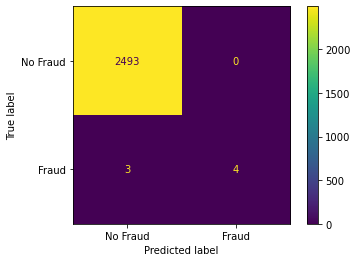

In [58]:
# More visual representation
plot_confusion_matrix(cred_model, X_test_sc, y_test, display_labels=['No Fraud', 'Fraud']);

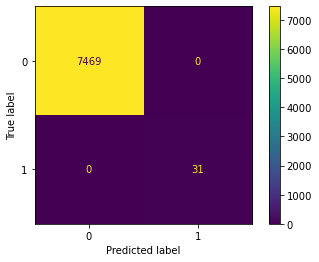

In [26]:
# Overfit on training
plot_confusion_matrix(cred_model, X_train_sc, y_train);

Notice the way that sklearn displays its confusion matrix: The rows are \['actually false', 'actually true'\]; the columns are \['predicted false', 'predicted true'\].

So it displays:

$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}$

**Question:** Do you see anything surprising in the confusion matrix?

hitting all the zeros (no fraud) but missing almost half the actually 1s (fraud)

## Classification Metrics

Let's calculate some common classification metrics and consider which would be most useful for this scenario.

In [27]:
tn = cm_1[0, 0]
fp = cm_1[0, 1]
fn = cm_1[1, 0]
tp = cm_1[1, 1]

## Accuracy

**Accuracy** = $\frac{TP + TN}{TP + TN + FP + FN}$

In words: How often did my model correctly identify transactions (fraudulent or not fraudulent)? This should give us the same value as we got from the `.score()` method.

In [28]:
acc = (tp + tn) / (tp + tn + fp + fn)
print(acc)

0.9988


In [29]:
# Via sklearn
accuracy_score(y_test, y_pred)

0.9988

## Recall

**Recall** = **Sensitivity** = $\frac{TP}{TP + FN}$

In words: How many of the actually fraudulent transactions did my model identify? 

In [30]:
rec = tp / (tp + fn)
print(rec)

0.5714285714285714


In [31]:
# Via sklearn
recall_score(y_test, y_pred)

0.5714285714285714

**Question:** Do you think a credit card company would consider recall to be an important metric? Why or why not?

## Precision

**Precision** = $\frac{TP}{TP + FP}$

In words: How often was my model's prediction of 'fraudulent' correct?

In [32]:
prec = tp / (tp + fp)
print(prec)

1.0


In [33]:
# Via sklearn
precision_score(y_test, y_pred)

1.0

**Question:** Do you think a credit card company would care more about recall or precision?

## $F$-Scores

The $F$-score is a combination of precision and recall, which can be useful when both are important for a business problem. 

Most common is the **$F_1$ Score**, which is an equal balance of the two using a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean).

$$F_1 = 2 \frac{Pr \cdot Rc}{Pr + Rc} = \frac{2TP}{2TP + FP + FN}$$

> _Recall a ***score** typically means higher is better_

In [36]:
f1_scores = 2*prec*rec / (prec + rec)
print(f1_scores)

0.7272727272727273


In [37]:
# Via sklearn
f1_score(y_test, y_pred)

0.7272727272727273

**Question:** Which of these metrics do you think a credit card company would care most about when trying to flag fraudulent transactions to deny?

We can generalize this score to the **$F_\beta$ Score** where increasing $\beta$ puts more importance on _recall_:

$$F_\beta =  \frac{(1+\beta^2) \cdot Precision \cdot Recall}{\beta^2 \cdot Precision + Recall}$$

## `classification_report()`

You can get all of these metrics using the `classification_report()` function. 

- The top rows show statistics for if you treated each label as the "positive" class
- **Support** shows the sample size in each class
- The averages in the bottom two rows are across the rows in the class table above (useful when there are more than two classes)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2493
           1       1.00      0.57      0.73         7

    accuracy                           1.00      2500
   macro avg       1.00      0.79      0.86      2500
weighted avg       1.00      1.00      1.00      2500



# Exercise: Breast Cancer Prediction

Let's evaulate a model using Scikit-Learn's breast cancer dataset:

In [ ]:
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test


# Scale the data


# Run the model
bc_model = 


## Task

Calculate the following for this model:

- Confusion Matrix
- Accuracy
- Precision
- Recall
- F1 Score

Discuss: Which one would you choose to evaluate the model for use as a diagnostic tool to detect breast cancer? Why?

In [ ]:
# Your work here

In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

# Multiclass Classification

What if our target has more than two classes?

**Multiclass classification** problems have more than two possible values for the target. For example, your target would have 10 possible values if you were trying to [classify an image of a hand-written number as a digit from 0 to 9](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). 

In these cases, we can use the same methods to evaluate our models. Confusion matrices will no longer be 2x2, but will have a number of rows/columns equal to the number of classes. 

When calculating metrics like precision, we choose one class to be the "positive" class, and the rest are assigned to the "negative" class. 

An example of comparing multiclass confusion matrices (letter recognition for two different models from [this repo](https://github.com/MrGeislinger/ASLTransalation)):

![https://github.com/MrGeislinger/ASLTransalation/blob/main/fingerspelling/paper/images/resnet50_confusionMatrix.png](images/resnet50_confusionMatrix.png)
![https://raw.githubusercontent.com/MrGeislinger/ASLTransalation/main/fingerspelling/paper/images/vgg16_confusionMatrix.png](images/vgg16_confusionMatrix.png)

# Summary: Which Metric Should I Care About?

Well, it depends.

Accuracy:
- Pro: Takes into account both false positives and false negatives.
- Con: Can be misleadingly high when there is a significant class imbalance. (A lottery-ticket predictor that *always* predicts a loser will be highly accurate.)

Recall:
- Pro: Highly sensitive to false negatives.
- Con: No sensitivity to false positives.

Precision:
- Pro: Highly sensitive to false positives.
- Con: No sensitivity to false negatives.

F-1 Score:
- Harmonic mean of recall and precision.

The nature of your business problem will help you determine which metric matters.

Sometimes false positives are much worse than false negatives: Arguably, a model that compares a sample of crime-scene DNA with the DNA in a city's database of its citizens presents one such case. Here a false positive would mean falsely identifying someone as having been present at a crime scene, whereas a false negative would mean only that we fail to identify someone who really was present at the crime scene as such.

On the other hand, consider a model that inputs X-ray images and predicts the presence of cancer. Here false negatives are surely worse than false positives: A false positive means only that someone without cancer is misdiagnosed as having it, while a false negative means that someone with cancer is misdiagnosed as *not* having it.

# Level Up: Cost Matrix

One might assign different weights to the costs associated with false positives and false negatives. (We'll standardly assume that the costs associated with *true* positives and negatives are negligible.)

**Example**. Suppose we are in the DNA prediction scenario above. Then we might construct the following cost matrix:

In [41]:
cost = np.array([[0, 10], [3, 0]])
cost

array([[ 0, 10],
       [ 3,  0]])

This cost matrix will allow us to compare models if we have access to those models' rates of false positives and false negatives, i.e. if we have access to the models' confusion matrices!

**Problem**. Given the cost matrix above and the confusion matrices below, which model should we go with?

In [42]:
conf1, conf2 = np.array([[100, 10], [30, 300]]), np.array([[120, 20], [0, 300]])

print(conf1, 2*'\n', conf2)

[[100  10]
 [ 30 300]] 

 [[120  20]
 [  0 300]]


In [44]:
cost1 = (10*10) + (30*3)
cost2 = (20*10) + (0*3)
cost1, cost2

(190, 200)

# Level Up: Multiclass Example

In [45]:
flowers = load_iris()

In [46]:
print(flowers.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [47]:
dims_train, dims_test, spec_train, spec_test = train_test_split(flowers.data,
                                                                flowers.target,
                                                                test_size=0.5,
                                                               random_state=42)

In [48]:
spec_train[:5]

array([1, 2, 1, 0, 1])

In [49]:
ss_f = StandardScaler()

ss_f.fit(dims_train)

dims_train_sc = ss_f.transform(dims_train)
dims_test_sc = ss_f.transform(dims_test)

In [50]:
logreg_f = LogisticRegression(multi_class='multinomial',
                             C=0.01, random_state=42)

logreg_f.fit(dims_train_sc, spec_train)

LogisticRegression(C=0.01, multi_class='multinomial', random_state=42)

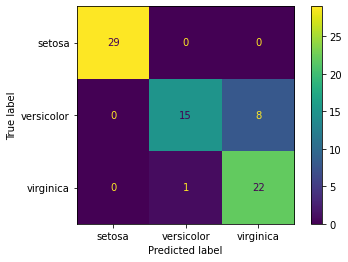

In [51]:
plot_confusion_matrix(estimator=logreg_f,
                      X=dims_test_sc,
                      y_true=spec_test,
                     display_labels=[
                         'setosa',
                         'versicolor',
                         'virginica'
                            ]);

In [52]:
print(classification_report(spec_test,
              logreg_f.predict(dims_test_sc)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.94      0.65      0.77        23
           2       0.73      0.96      0.83        23

    accuracy                           0.88        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.90      0.88      0.88        75



In [57]:
precision_score(spec_test, logreg_f.predict(dims_test_sc), average='weighted')

0.8990555555555556